# Imports and helper functions

In [2]:
import torch
import matplotlib.pylab as plt
from env import VanillaEnv
from typing import List
from torchvision.utils import make_grid
from rl.common.buffer2 import Transition, Episode
import numpy as np
from env import generate_expert_trajectory
import time
import psm

In [3]:
def compare_2imgs(a,b,title:str = ""):
   f, axarr = plt.subplots(1,2)
   axarr[0].imshow(np.flipud(a.squeeze()), cmap='gray', vmin=0., vmax=1.)
   axarr[1].imshow(np.flipud(b.squeeze()), cmap='gray', vmin=0., vmax=1.)
   if len(title) > 0: plt.title(title)
   plt.show()
def compare_imgs(a,b,c,title:str = ""):
   f, axarr = plt.subplots(1,3)
   axarr[0].imshow(np.flipud(a.squeeze()), cmap='gray', vmin=0., vmax=1.)
   axarr[1].imshow(np.flipud(b.squeeze()), cmap='gray', vmin=0., vmax=1.)
   axarr[2].imshow(np.flipud(c.squeeze()), cmap='gray', vmin=0., vmax=1.)
   if len(title) > 0: plt.title(title)
   plt.show()

In [4]:
states_x, actions_x = generate_expert_trajectory(VanillaEnv(configurations=[(26, 5)]))
states_y, actions_y = generate_expert_trajectory(VanillaEnv(configurations=[(34, 35)]))

# Manual calculation of PSE

First MPD:
| $x_n \sim \mathcal{X}$ | $x_1$  | $x_2$  | $x_3$|$x_4$|$x_5$|
|-:|:-:|:-:|:-:|:-:|:-:|
| $\pi_\mathcal{X}^*(x)$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}0\\1\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|
| $\arg \max(\pi_\mathcal{X}^*(x))$ |0|0|0|1|0|

Second MPD:
| $y_n \sim \mathcal{Y}$|$y_1$|$y_2$|$y_3$|$y_4$|$y_5$|
|-:|:-:|:-:|:-:|:-:|:-:|
| $\pi_\mathcal{Y}^*(y)$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}0\\1\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|
| $\arg \max(\pi_\mathcal{Y}^*(y))$ |0|1|0|0|0|

$
\begin{align}
d^*(x,y) &= TV(\pi_\mathcal{X}^*(\cdot |x), \pi_\mathcal{Y}^*(\cdot |y)) + \gamma W_1(d^*)\left( P_\mathcal{X}^{\pi^*}(\cdot|x),P_\mathcal{Y}^{\pi^*}(\cdot|y) \right) 
\\
d^*(x_i,y_j) &= TV(\arg \max(\pi_\mathcal{X}^*(x_i)),\arg \max(\pi_\mathcal{Y}^*(y_j))) + \gamma d^*(x_{i+1}, y_{j+1})
\\
d^*(x_i,y_j) &= TV(a_{\mathcal{X}, i}^*,a_{\mathcal{Y}, i}^*) + \gamma d^*(x_{i+1}, y_{j+1})
\\[.4cm]
\text{for two specific states (see table above):}
\\
d^*(x_2,y_2) &= TV(0,1) + \gamma \cdot d^*(x_3,y_3) \\
&= TV(0,1) + \gamma \cdot TV(0,0) + \gamma^2  \cdot TV(1,0) + \gamma^3 \cdot TV(0,0) \\
&= 1 + \gamma^2 = 1.9801
\end{align}
$

|$d(x_1, y_1)$|$d(x_1, y_2)$|$d(x_1, y_3)$|$d(x_1, y_4)$|$d(x_1, y_5)$|
|:-:|:-:|:-:|:-:|:-:|
|$d(x_2, y_1)$|$d(x_2, y_2)$|$d(x_2, y_3)$|$d(x_2, y_4)$|$d(x_2, y_5)$|
|$d(x_3, y_1)$|$d(x_3, y_2)$|$d(x_3, y_3)$|$d(x_3, y_4)$|$d(x_3, y_5)$|
|$d(x_4, y_1)$|$d(x_4, y_2)$|$d(x_4, y_3)$|$d(x_4, y_4)$|$d(x_4, y_5)$|
|$d(x_5, y_1)$|$d(x_5, y_2)$|$d(x_5, y_3)$|$d(x_5, y_4)$|$d(x_5, y_5)$|

$d(x_5, y_5) = TV(a_{x5}, a_{y5}) = TV(0,0) = 0$ <br>
$d(x_4, y_4) = TV(a_{x4}, a_{y4}) + \gamma \cdot TV(a_{x5}, a_{y5}) = TV(1,0) = 1$ <br>
$d(x_3, y_3) = TV(a_{x3}, a_{y3}) + \gamma \cdot TV(a_{x4}, a_{y4}) = TV(0,0) + \gamma \cdot 1 = 0.99$ <br>
$d(x_2, y_2) = TV(a_{x2}, a_{y2}) + \gamma \cdot TV(a_{x3}, a_{y3}) = TV(0,1) + \gamma \cdot 0.99 = 1.9801$ <br>
$d(x_1, y_1) = TV(a_{x1}, a_{y1}) + \gamma \cdot TV(a_{x2}, a_{y2}) = TV(0,0) + \gamma \cdot 1.9801 = 1.960299$ <br>

Is the following really correct? If there is no state $y_{i+1}$ then we just take $y_{i}$? Where is this indicated in the formulars? 

$d(x_4, y_5) = TV(a_{x4}, a_{y5}) + \gamma \cdot TV(a_{x5}, a_{y5}) = TV(1,0) + \gamma \cdot 0 = 1$<br>
$d(x_3, y_5) = TV(a_{x3}, a_{y5}) + \gamma \cdot TV(a_{x4}, a_{y5}) = TV(0,0) + \gamma \cdot 1 = 0.99$<br>
$d(x_2, y_5) = TV(a_{x2}, a_{y5}) + \gamma \cdot TV(a_{x3}, a_{y5}) = TV(0,0) + \gamma \cdot 0.99 = 0.9801$<br>
$d(x_1, y_5) = TV(a_{x1}, a_{y5}) + \gamma \cdot TV(a_{x2}, a_{y5}) = TV(0,0) + \gamma \cdot 0.9801 = 0.970299$<br>

Without recursion: <br>
$\begin{align}
d(x_1, y_3) &= \gamma^0 TV(a_{x1}, a_{y3}) + \gamma^1 TV(a_{x2}, a_{y4}) + \gamma^2 TV(a_{x3}, a_{y5}) + \gamma^3 TV(a_{x4}, a_{y5}) + \gamma^4 TV(a_{x5}, a_{y5})\\
&= \gamma^0 TV(0,0) + \gamma^1 TV(0,0) + \gamma^2 TV(0,0) + \gamma^3 TV(1,0) + \gamma^4 TV(0,0)\\
&=  \gamma^3 = 0.970299
\end{align}$


# PSE on dummy transitions

In [5]:
# calculate PSM for specific states x and y
def psm_single(x_arr, y_arr, x_idx, y_idx, gamma=0.99):
    """
    Calculates the psm for the enire sequence (starting at the first element)
    """
    tv = 0. if x_arr[x_idx] == y_arr[y_idx] else 1.
    if(x_idx == len(x_arr)-1 and y_idx == len(y_arr)-1):
        return tv
    else:
        return tv + gamma * psm_single(x_arr,y_arr, min(x_idx+1, len(x_arr)-1), min(y_idx+1, len(y_arr)-1), gamma)


for i in range(0,5):
    for j in range(0,5):
        print(f"{psm_single([0,0,0,1,0], [0,1,0,0,0], x_idx = i, y_idx=j):.6f}", end=', ')
    print("")

1.960299, 1.970299, 0.970299, 0.970299, 0.970299, 
1.970100, 1.980100, 0.980100, 0.980100, 0.980100, 
0.000000, 1.990000, 0.990000, 0.990000, 0.990000, 
1.990000, 0.000000, 1.000000, 1.000000, 1.000000, 
0.990000, 1.000000, 0.000000, 0.000000, 0.000000, 


In [6]:
# calculate it like in the paper
print(psm.psm_paper([0,0,0,1,0], [0,1,0,0,0]))

[[1.960299   1.970299   0.97029907 0.97029907 0.97029907]
 [1.9701     1.9801     0.98010004 0.98010004 0.98010004]
 [0.         1.99       0.99       0.99       0.99      ]
 [1.99       0.         1.         1.         1.        ]
 [0.99       1.         0.         0.         0.        ]]


In [7]:
# calculate psm for all states from X and Y 
print(psm.psm_default([0,0,0,1,0], [0,1,0,0,0]))

[[1.960299 1.970299 0.970299 0.970299 0.970299]
 [1.9701   1.9801   0.9801   0.9801   0.9801  ]
 [0.       1.99     0.99     0.99     0.99    ]
 [1.99     0.       1.       1.       1.      ]
 [0.99     1.       0.       0.       0.      ]]


In [8]:
# calcualte psm forward and backward
print(psm.psm_fb([0,0,0,1,0], [0,1,0,0,0]))

[[1.960299 2.970299 1.960299 1.950399 1.940598]
 [1.9701   2.9801   1.9701   1.9602   1.950399]
 [0.       2.99     1.98     1.9701   1.960299]
 [2.99     0.       2.99     2.9801   2.970299]
 [1.98     2.99     0.       1.9701   1.960299]]


# PSE on jumping task

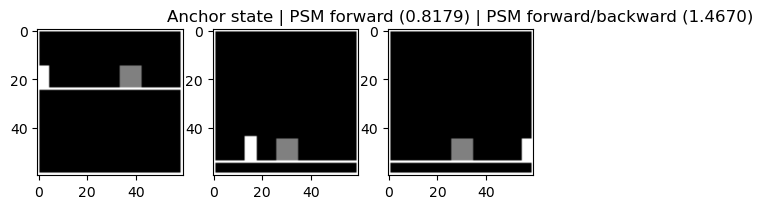

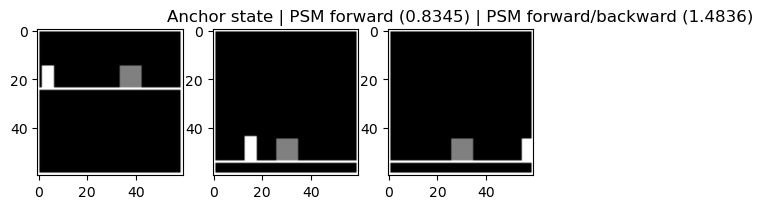

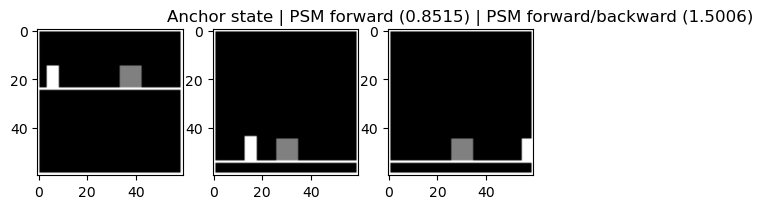

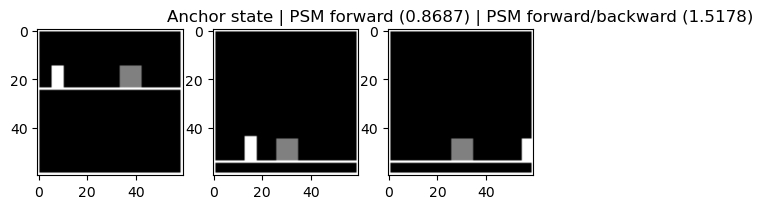

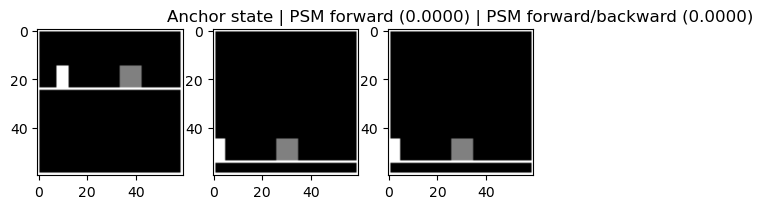

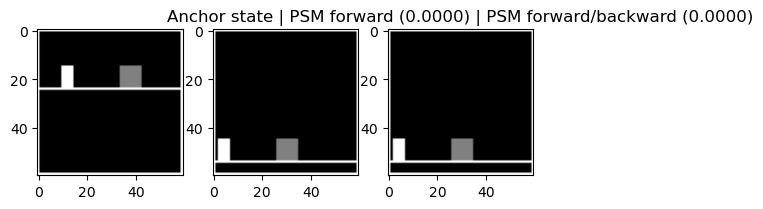

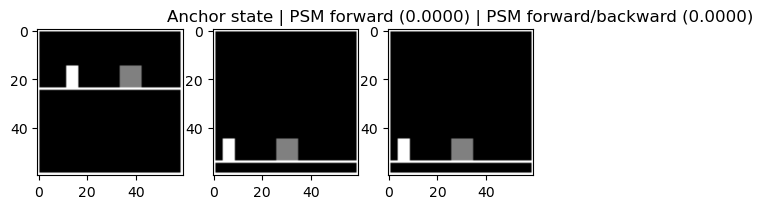

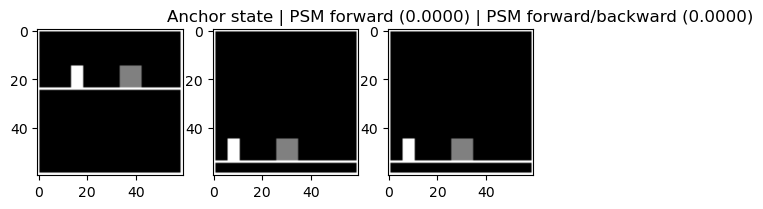

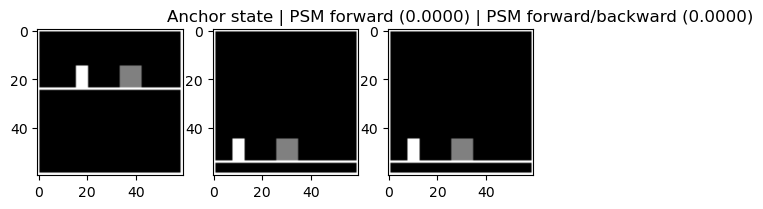

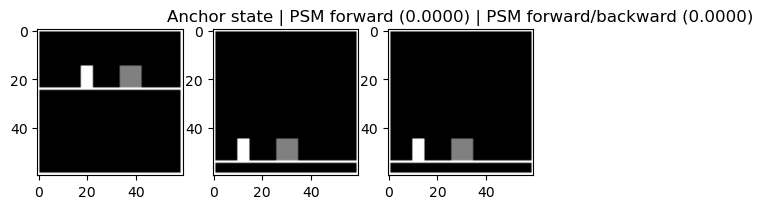

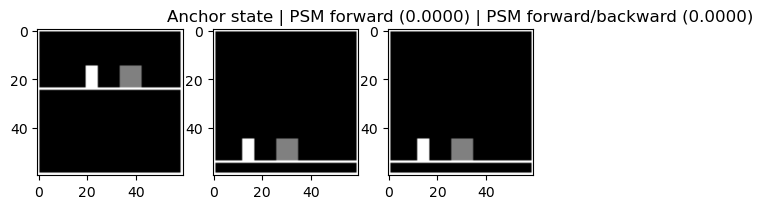

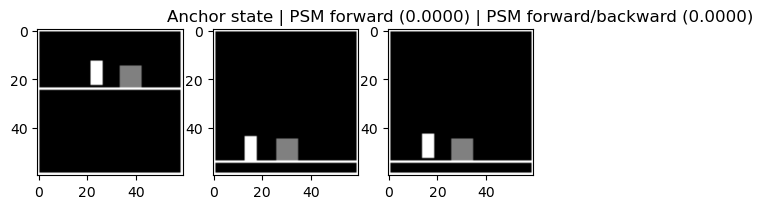

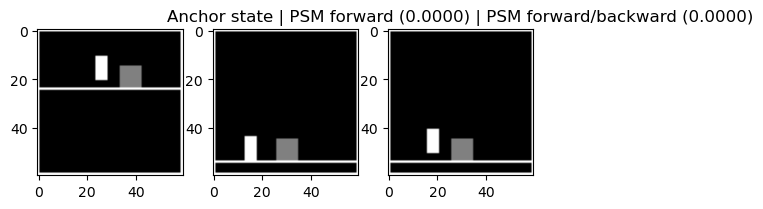

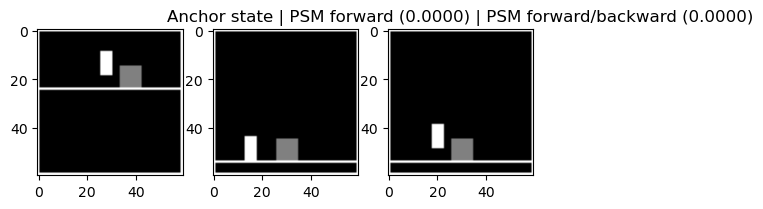

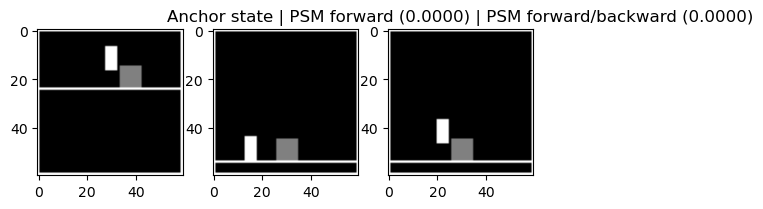

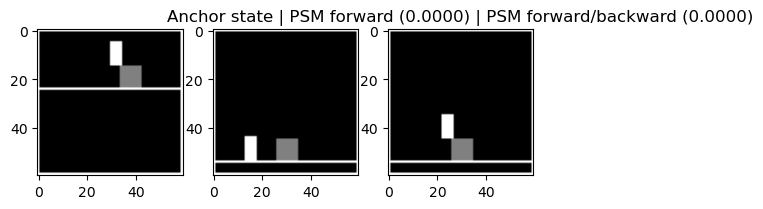

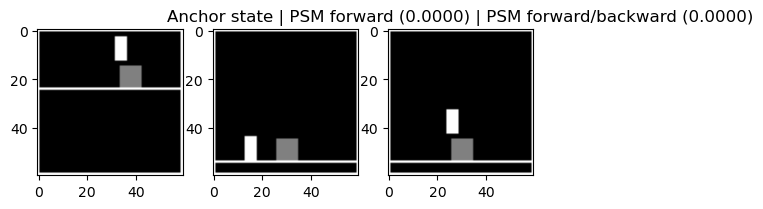

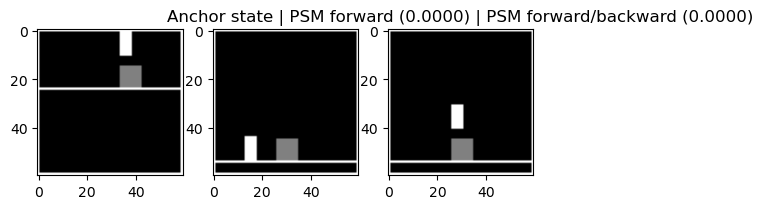

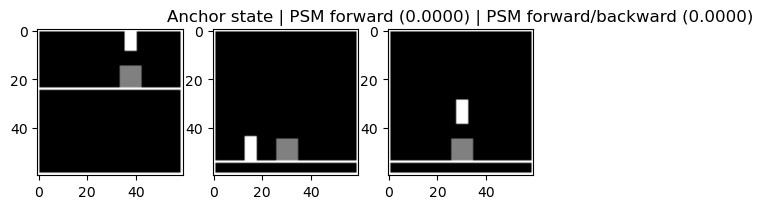

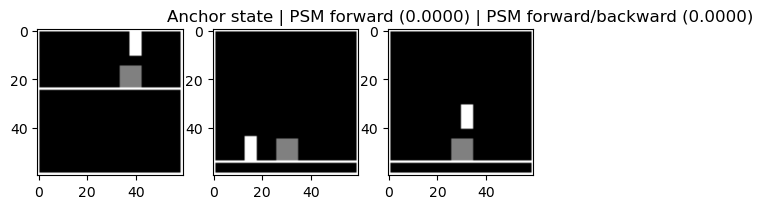

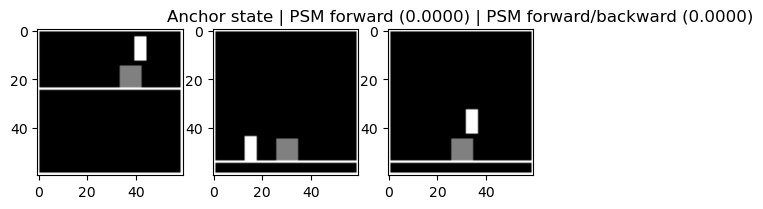

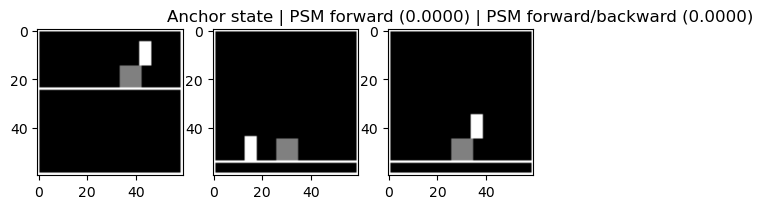

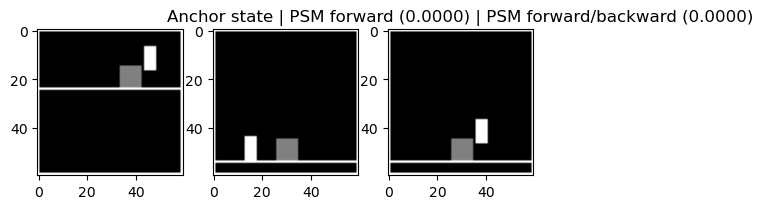

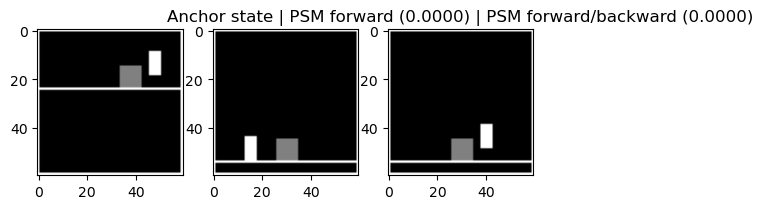

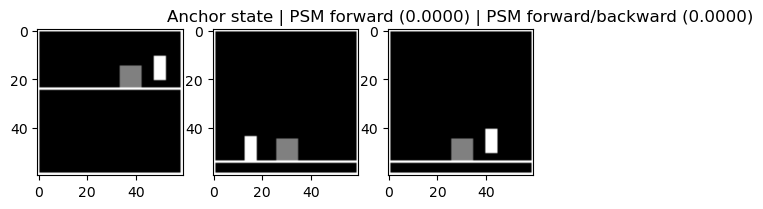

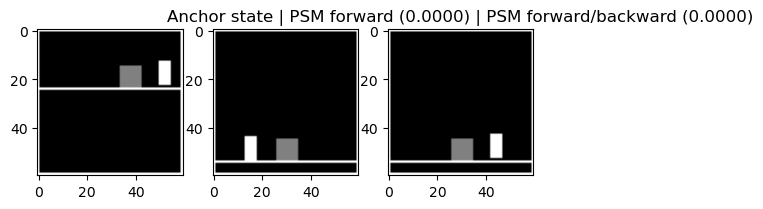

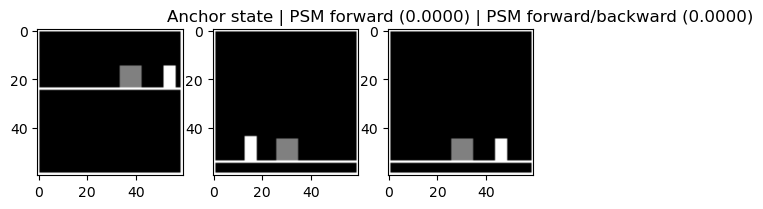

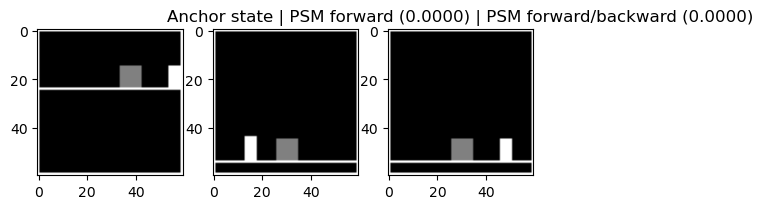

In [9]:
psm_forward = psm.psm_default(actions_y, actions_x)
psm_fb = psm.psm_fb(actions_y, actions_x)


assert np.allclose(psm_forward, psm.psm_paper(actions_y,actions_x)) , "My method computes other PSM values than the one from the paper!"

for compare_idx in range(0, len(actions_y)):                            
    # Given the state at index compare_idx, which state in Y is most similar?
    idx_forward = np.argmin(psm_forward[compare_idx])
    idx_fb = np.argmin(psm_fb[compare_idx])

    if compare_idx % 2 == 0:
        compare_imgs(
            states_y[compare_idx], 
            states_x[idx_forward], 
            states_x[idx_fb], 
            f"Anchor state | PSM forward ({psm_forward[compare_idx][idx_forward]:.4f}) | PSM forward/backward ({psm_fb[compare_idx][idx_fb]:.4f})")
